In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
import csv
import subprocess
import sys
sys.path.append('../')
from CAS import *


In [2]:
## this assumes community 0 are outliers and 'gt' exists in graph G
## M: membership matrix
## S: score matrix (C or Beta)
def outliers_AUC(G, M, S):
    y = [int(x>0) for x in G.vs['gt']]
    x = np.array(S.max(axis=1).todense()).flatten()
    ctr = Counter(np.array(M.sum(axis=1)).flatten())
    print('With matrix M:\noutliers:',ctr[0])
    print('correct outliers:',sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(G.vs['gt']) == 0)))
    print('\nWith scores:\noutlier AUC:',AUC(y,x)) 
        

## ABCD-oo graphs

Main 2 files:

```
networkfile<xi>_<eta>_<rep>.txt : the edges, 1-based node ids, tab separated
communityfile<xi>_<eta>_<rep>.txt : node <tab> list of communities in [], for example:
1       [24]
2       [3, 28]
3       [10]
```

All files for one case:

```
communityfile0.5_1.5_10.txt
communitysizesfile0.5_1.5_10.txt
degreefile0.5_1.5_10.txt
networkfile0.5_1.5_10.txt
```

All graph have 250 outlier nodes, mapped to community 0 below


In [3]:
#path = '/data/ABCDoo/'
path = '../Datasets/ABCDoo/'
def readGraph(xi=0.5, eta=1.5, rep=1):
    ## read edges, build graph
    fn = path+'networkfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1 ## map to 0-based
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'communityfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G
   

In [4]:
oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi'          ## overlapping NMI executable
#oNMI = '/work/home/fcthebe/Tools/oNMI/onmi'          ## overlapping NMI executable

## input format: 
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x


In [5]:
def memberships2list(S):
    L = []
    for i in range(len(S.indptr)-1):
        if S.indptr[i] == S.indptr[i+1]:
            L.append([0]) ## no membership == outlier (community 0)
        else:
            L.append(list(S.indices[S.indptr[i]:S.indptr[i+1]]+1)) ## 1-based
    return L

## given list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L

In [6]:
from itertools import combinations
def CPM(g, k=3):
    cls = list(map(set, g.cliques(min=k,max=k)))
    edgelist = []
    for i in range(len(cls)):
        edgelist.append((i,i))
    for i,j in combinations(range(len(cls)),2):
        if len(cls[i].intersection(cls[j])) >= (k-1):
            edgelist.append((i,j))
    cg = ig.Graph(edgelist, directed=False)
    clusters = cg.connected_components()
    L = []
    for cluster in clusters:
        members = set()
        for i in cluster:
            members.update(cls[i])
        L.append(set(g.vs[members]["name"]))
    return L


In [7]:
def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP or ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    #ctr = 1
    for nm in names:
#         if ctr%1000==0:
#             print(ctr)
#         ctr+=1
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32)
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


In [20]:
def Jaccard(a,b):
    x = len(set(a).intersection(set(b)))/len(set(a).union(set(b)))
    return x

def weightedLinegraph(g):
    lg = g.linegraph()
    w=[]
    for e in lg.es:
        A = set(g.es[e.tuple[0]].tuple)
        B = set(g.es[e.tuple[1]].tuple)
        x = list((A-B).union(B-A))
        w.append(Jaccard(g.neighbors(x[0]),g.neighbors(x[1])))
    lg.es['weight'] = w
    return lg

def edgeCluster(g, color=False):
    q = -999
    D = weightedLinegraph(g)
    for th in sorted(set(D.es['weight'])):
        ## filter edges w.r.t. similarity and find CC
        dg = D.copy()
        dg.delete_edges([e for e in dg.es if e['weight']<=th])
        cc = dg.connected_components().membership
        mod = D.modularity(cc)
        if mod>q:
            q = mod
            g.es['lc'] = cc
            if color:
                pal = ig.ClusterColoringPalette(n=max(cc)+1)
                for e in g.es:
                    e['color'] = pal[e['lc']]
    ## Now gather the nodes for each edge cluster
    L = []
    for i in range(max(g.es['lc'])+1):
        sg = g.subgraph_edges([e for e in g.es if e['lc']==i])
        L.append(sg.vs['name'])
    return L

## Quick test

In [14]:
xi = 0.35
eta = 1.0

G = readGraph(xi=xi, eta=eta, rep=1)
G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
GT = mems2comms(G.vs['comms'])[1:]  ## ignore "outlier community"
GT = [[str(i) for i in x] for x in GT]

In [15]:
%%time
CP = CPM(G)


CPU times: user 1min 30s, sys: 290 ms, total: 1min 30s
Wall time: 1min 30s


In [16]:
%%time
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
LD = mems2comms([[x] for x in G.vs['leiden']])
LD = [[str(i) for i in j] for j in LD]


CPU times: user 85.4 ms, sys: 3.25 ms, total: 88.7 ms
Wall time: 87.5 ms


In [17]:
%%time
comms_es = EgoSplit(G, split='CC', algo='ECG')
ES = [list(x) for x in comms_es if len(x)>=10]


CPU times: user 11min 25s, sys: 1.26 s, total: 11min 26s
Wall time: 11min 26s


In [18]:
%%time
C = sparse.csc_matrix((G.vcount(),len(ES)))
C.indices = np.array([int(i) for j in ES for i in j])
C.data = np.repeat(1,len(C.indices))
ptr = [0]
ctr = 0
for x in ES:
    ctr += len(x)
    ptr.append(ctr)
C.indptr = np.array(ptr)
M = C.tocsr()
## Beta
IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
L = []
th = 0.1
for i in range(Beta.shape[1]):
    x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
    if len(x)>0:
        L.append(list(x))        

CPU times: user 2.45 s, sys: 17.7 ms, total: 2.47 s
Wall time: 2.46 s


In [ ]:
%%time
EC = edgeCluster(G)

In [ ]:
compute_oNMI(EC,GT)


In [19]:
X = [eta, compute_oNMI( CP, GT ), compute_oNMI( LD, GT ), compute_oNMI( ES, GT ), compute_oNMI(GT, L), xi]
print(X)


[1.0, 0.130833, 0.954705, 0.686449, 0.762599, 0.35]


## Compare algorithms: CPM, Leiden, Ego-Split, ES+Beta


In [8]:
with open('Results/algo_compare.pkl','rb') as fp:
    df = pickle.load(fp)
df.columns = ['eta', 'CPM', 'Leiden', 'EgoSplit', 'EgoSplit+CAS', 'xi']

In [10]:
df

,eta,CPM,Leiden,EgoSplit,EgoSplit+CAS,xi
0,1.0,1.308330e-01,9.537800e-01,6.857900e-01,0.758943,0.35
1,1.5,2.629090e-02,3.272060e-01,3.597530e-01,0.526670,0.35
2,2.0,2.508050e-02,1.590650e-01,2.974040e-01,0.367987,0.35
3,2.5,2.079860e-02,1.371140e-01,1.638950e-01,0.248890,0.35
4,3.0,9.458360e-03,1.166880e-01,4.650820e-02,0.155460,0.35
0,1.0,6.275120e-02,9.459430e-01,4.242190e-01,0.593306,0.50
1,1.5,3.406070e-02,3.058010e-01,2.277080e-01,0.378483,0.50
2,2.0,3.656980e-02,1.601090e-01,1.354960e-01,0.250527,0.50
3,2.5,8.255580e-03,1.350690e-01,2.260950e-02,0.080059,0.50
4,3.0,1.038600e-03,1.054470e-01,1.039050e-03,0.011654,0.50


## Plots for WAW ABCD-oo paper

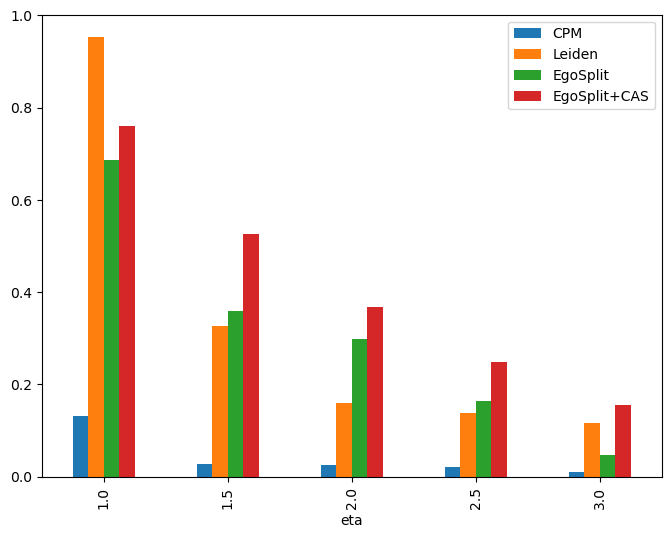

In [11]:
df[df.xi==.35].plot(x='eta',y=['CPM', 'Leiden', 'EgoSplit', 'EgoSplit+CAS'], kind='bar', figsize=(8,6));


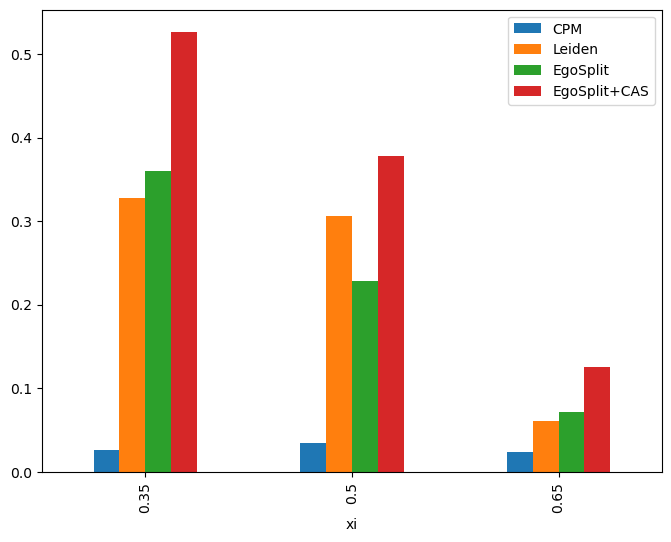

In [12]:
df[df.eta==1.5].plot(x='xi',y=['CPM', 'Leiden', 'EgoSplit', 'EgoSplit+CAS'], kind='bar', figsize=(8,6));


## Testing ES+AOC and IKC+AOC


### read ABCDoo, run Leiden, ES and Beta

In [ ]:
len([j for i in LEI for j in i])

In [ ]:
Results = []
rep = 3
xi = 0.35
for eta in [1.0,1.5,2.0,2.5,3.0]:
#for eta in [1.5]:

    fn = '~/Betastar/CommunityAssociationStrength/Datasets/ABCDoo/networkfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'

    ## read graph, compute Leiden
    G = readGraph(xi=xi, eta=eta, rep=rep)
    G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
    G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
    GT = mems2comms(G.vs['comms'])[1:]  ## ignore "outlier community"
    GT = [[str(i) for i in x] for x in GT]

    ## ego-split
    comms_es = EgoSplit(G, split='CC', algo='ECG')
    ES = [list(x) for x in comms_es if len(x)>=10]
    print('Ego:',compute_oNMI( ES, GT ))
    LEI = mems2comms([[c] for c in G.vs['leiden']])
    print('Leiden:',compute_oNMI(GT, LEI))

    ## ego+beta
    C = sparse.csc_matrix((G.vcount(),len(ES)))
    C.indices = np.array([int(i) for j in ES for i in j])
    C.data = np.repeat(1,len(C.indices))
    ptr = [0]
    ctr = 0
    for x in ES:
        ctr += len(x)
        ptr.append(ctr)
    C.indptr = np.array(ptr)
    M = C.tocsr()
    ## Beta
    IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
    EB = []
    th = 0.1
    for i in range(Beta.shape[1]):
        x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
        if len(x)>0:
            EB.append(list(x))        
    print('Ego+beta:',compute_oNMI(GT, EB))

    ## Leiden+beta
    C = sparse.csc_matrix((G.vcount(),len(LEI)))
    C.indices = np.array([int(i) for j in LEI for i in j])
    C.data = np.repeat(1,len(C.indices))
    ptr = [0]
    ctr = 0
    for x in LEI:
        ctr += len(x)
        ptr.append(ctr)
    C.indptr = np.array(ptr)
    M = C.tocsr()
    ## Beta
    IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
    LB = []
    th = 0.1
    for i in range(Beta.shape[1]):
        x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
        if len(x)>0:
            LB.append(list(x))        
    print('Leiden+beta:',compute_oNMI(GT, LB))
    
    ## store leiden clusters
    L = []
    for v in G.vs:
        L.append( (v['leiden'],str(int(v['name'])+1)) ) ## 1-based in edge file
    with open('_clusters.txt', 'w') as fp:
        fp.write('\n'.join('%s %s' % x for x in L))
        fp.write('\n')
    
    ## Leiden + AOC    
    cmd = 'python3 ~/Betastar/aocv2_plus/v2_revisions/aoc.py -g '+fn+' -c _clusters.txt --inclusion-criterion mcd > _aoc.txt'
    os.system('source activate complexnetworks && '+cmd)
    LA = []
    df = pd.read_csv('_aoc.txt', sep=' ', header=None, names=['comm','node'])
    for i in range(max(df.comm)+1):
        LA.append([str(v-1) for v in df[df.comm==i].node]) ## back to 0-based
    print('Leiden+AOC:',compute_oNMI(LA,GT))
    
    ## store ES clusters
    L = []
    for i in range(len(ES)):
        for j in ES[i]:
            L.append( (str(i),str(int(j)+1)) )
    with open('_clusters.txt', 'w') as fp:
        fp.write('\n'.join('%s %s' % x for x in L))
        fp.write('\n')
        
    ## ES + AOC    
    cmd = 'python3 ~/Betastar/aocv2_plus/v2_revisions/aoc.py -g '+fn+' -c _clusters.txt --inclusion-criterion mcd > _aoc.txt'
    os.system('source activate complexnetworks && '+cmd)
    EA = []
    df = pd.read_csv('_aoc.txt', sep=' ', header=None, names=['comm','node'])
    for i in range(max(df.comm)+1):
        EA.append([str(v-1) for v in df[df.comm==i].node]) ## back to 0-based
    print('ES+AOC:',compute_oNMI(EA,GT))
    
    X = [eta,compute_oNMI( ES, GT ), compute_oNMI(GT, LEI), compute_oNMI(GT, EB), compute_oNMI(GT, LB),
         compute_oNMI(LA,GT),compute_oNMI(EA,GT)]
    Results.append(X)

In [ ]:
_df = pd.DataFrame(Results, columns=['eta','Ego-Split','Leiden','Ego+Beta','Leiden+Beta','Leiden+AOC','Ego+AOC'])
with open('algo_compare_aoc.pkl','wb') as fp:
    pickle.dump(_df,fp)    

In [ ]:
_df

### run IKC

In [ ]:
cmd = 'python3 /Users/francois/Betastar/ERNIE_Plus/Illinois/clustering/eleanor/code/IKC.py -o _ikc -k 10 -e '+fn
os.system('source activate complexnetworks && '+cmd)
## IKC fails - single community with 3103 nodes
df = pd.read_csv('_ikc', header=None, names=['node','comm','k','q'])
Counter(df[df.k>0].comm)
